# 資料分析師的尋常一日 - 簡短分析 IMDB
今天要使用 python pandas 函式讀取的是 [IMDB 提供的 dataset](https://www.imdb.com/interfaces/)。 在這個 dataset 中，總共有七個檔案，都用 gzip 壓縮，而分別是：

| 檔案名稱                | 簡短中文註解                          |是否使用     
|:----------------------:|:---------------------------------:|:--------:|
|title.akas.tsv.gz       |影片的語言和地區等較為國際性的資料       |No|
|title.basics.tsv.gz     |影片的基本資料，如時間和發行年代        |Yes|
|title.crew.tsv.gz       |包括電影與人員有關，主要是導演和編劇的資料|Yes|
|title.episode.tsv.gz    |和電視影集相關的資訊                   |No|
|title.principals.tsv.gz |包括影片較為詳細的主要工作人員資料        |Mo|
|title.ratings.tsv.gz    |包括觀眾對於影片的評價資料               |No|
|name.basics.tsv.gz      |包括電影工作人員包括導演等的相關資料       |Yes|

如表格所示，今天我們只會用到三個檔案：title.basics.tsv, title.crew.tsv 和 name.basics.tsv。

今天的分析，是想知道《從前，有個好萊塢 ..》的導演昆丁塔倫提諾，是否有拍片長度變長的趨勢。這個問題來自於光與影的[臉書貼文](https://www.facebook.com/lightandshadowcinema/photos/a.953335314676769/2573460669330884)，其中提到一個關鍵是，昆丁塔倫提諾在 2010 年失去了長期合作的剪輯師後，則呈現冗長的傾向。

分析的流程是：先讀入檔案，找出昆丁塔倫提諾的名字代碼（name.basics.tsv），對應到角色為導演的電影（title.crew.tsv），取出電影的官方公佈時間長（title.basics.tsv），繪製昆丁塔倫提諾導演在執導期間的所有片長時間。

In [3]:
import pandas as pd
import csv

basics = pd.read_csv('../input/title.basics.tsv', index_col='tconst',
                     delimiter ='\t', na_values=['\\N', '\\\\N'])

/Users/renewang/anaconda3/envs/workenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
basics.dtypes

titleType          object
primaryTitle       object
originalTitle      object
isAdult             int64
startYear         float64
endYear           float64
runtimeMinutes     object
genres             object
dtype: object

因為 pandas.read_csv 在執行時，發出警告訊息，告訴我們第七欄有混合型別。另外在檢查 title.basics 的表格時，發現 runtimeMinutes 的資料型態為 object，這顯然不是我們希望的結果，我們得去找出問題出在哪裡。第一個除錯的地方可能是把未能成功轉成數值型態的值給列印出來。

In [5]:
cond = basics['runtimeMinutes'].str.contains('[a-zA-Z]+', na=False)

In [6]:
w = pd.read_csv('../input/title.basics.tsv', delimiter ='\t') # by not using tconst as index
                                                              # will give us a hit of line #
cond = cond.reset_index()
w[cond['runtimeMinutes']]

/Users/renewang/anaconda3/envs/workenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
1102406,tt10233364,tvEpisode,Rolling in the Deep Dish\tRolling in the Deep ...,0,2019,\N,\N,Reality-TV,NaN
3319722,tt3984412,tvEpisode,"I'm Not Going to Come Last, I'm Just Going to ...",0,2014,\N,\N,Reality-TV,NaN
5069611,tt7841930,tvEpisode,Stop and Hear the Cicadas/Cold-Blooded\tStop a...,0,2018,\N,24,"Animation,Family",NaN
5490981,tt8740950,tvEpisode,Weight Loss Resolution Restart - Ins & Outs of...,0,2015,\N,\N,Reality-TV,NaN
6041502,tt9900062,tvEpisode,The Direction of Yuu's Love: Hings Aren't Goin...,0,1994,\N,\N,"Animation,Comedy,Drama",NaN


In [7]:
!sed -n '1102408, 1102408'p ../input/title.basics.tsv

tt10233364	tvEpisode	"Rolling in the Deep Dish	"Rolling in the Deep Dish	0	2019	\N	\N	Reality-TV


藉由列印出有問題的列，可以發現原檔案中有使用雙引號，但其數量是不對稱的，也就是說用在 *primaryTitle* 欄位的雙引號，包住了分隔符號，也就是 \t 。而原本分配給 *primaryTitle* 和 *originalTitle* 兩個欄位的值，在不當使用雙引號後，全都分配給了 *primaryTitle* ，造成了解析後的欄位減少！   

看到這裡，有些新手可能會覺得恐慌，難道我們要改寫 pandas 嗎？但事實上，解決這個問題非常簡單，如果你熟悉 csv 檔的話！這時，就讓我們垂降至架構 pandas.read_csv 底層的函式，也是 python standard library， csv 模組。

我們可以看到，在 [csv 模組](https://docs.python.org/3/library/csv.html) 中針對 quoting （引號）定義了一些在寫入時，如何處理引號的部分。 他們包括了：

- csv.QUOTE_ALL: 不管每一個欄位裝什麼東西，一律都用引用符號（可以是單引號或是雙引號）來包住。
- csv.QUOTE_MINIMAL： 只要該欄位有特別的字元，如分隔符號，引號到分隔或分行符號，才使用引用符號來包住。
- csv.QUOTE_NONNUMERIC：同上，但使用引號的標準是當欄位包括文字時，或非數值的字元。在讀取時，會將未使用引號的欄位，都轉成數值型態。
- csv.QUOTE_NONE：不使用引用

看起來 csv.QUOTE_NONE 比較像我們的需求，所以我們將這個參數帶入 pandas.read_csv 中

In [8]:
basics = pd.read_csv('../input/title.basics.tsv', index_col='tconst',
                     delimiter ='\t', na_values=['\\N', '\\\\N'], quoting=csv.QUOTE_NONE)

In [9]:
basics.dtypes

titleType          object
primaryTitle       object
originalTitle      object
isAdult             int64
startYear         float64
endYear           float64
runtimeMinutes    float64
genres             object
dtype: object

很好，我們順利的將 runtimeMinutes 轉成了 float64。但，大家可能覺得很奇怪，包括 startYear，endYear 為何是 float 型態。這一切都是萬惡的 np.nan 主要型態是 float，而且沒有 integer 的對應版本。至於為何 np.nan 會是浮點數，pandas 的 release team 則將他們的回答寫在常見的 [FAQ: NaN, Integer NA values and NA type promotions](https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html#nan-integer-na-values-and-na-type-promotions)

大家可以看以下的表格，了解 missing values 在不同的資料型態被表示的方式。

| Type	|Represents missing values |
|-------|------------------|
|floating : float64, float32, float16|	np.nan|
|integer : int64, int32, int8, uint64,uint32, uint8	|| 
|boolean|||	 
|datetime64[ns]|	NaT|
|timedelta64[ns]|	NaT|
|categorical : see the section below|	 
|object : strings|	np.nan|

無論如何，為了節省記憶體空間，我們把這些資料型態從 64 位元壓縮到 32 位元，畢竟他們原本是正整數。

In [10]:
for col in basics.columns:
  if str(basics[col].dtype).endswith('64'):
    from_dtype = str(basics[col].dtype)[:-2]
    basics[col] = basics[col].astype('%s32'%from_dtype)
basics.dtypes

titleType          object
primaryTitle       object
originalTitle      object
isAdult             int32
startYear         float32
endYear           float32
runtimeMinutes    float32
genres             object
dtype: object

接著我們來讀進其他檔案。這些檔案和主要檔案的關係如下圖：

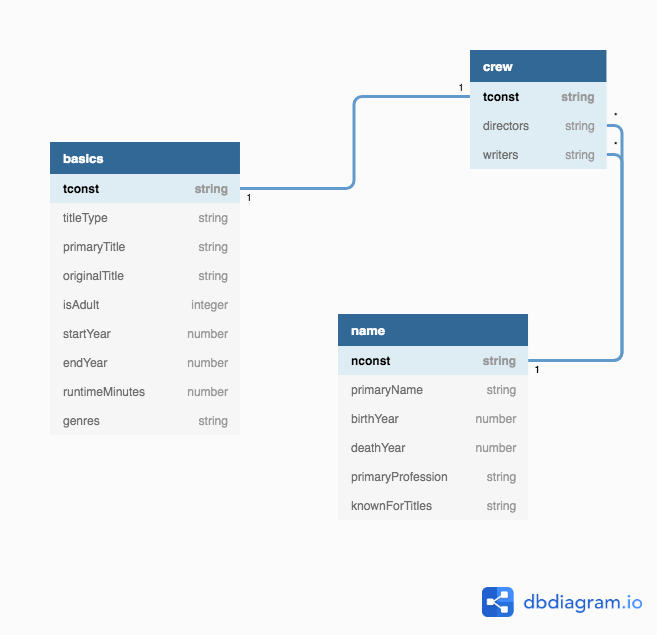

In [58]:
from IPython.display import Image 
Image(data='dbdiagram.png', embed=True)

In [11]:
crew = pd.read_csv('../input/title.crew.tsv', delimiter ='\t', na_values=['\\N', '\\\\N'], index_col='tconst')

In [12]:
crew.head()

,directors,writers
tconst,,
tt0000001,nm0005690,NaN
tt0000002,nm0721526,NaN
tt0000003,nm0721526,NaN
tt0000004,nm0721526,NaN
tt0000005,nm0005690,NaN


In [13]:
name = pd.read_csv('../input/name.basics.tsv', delimiter ='\t', na_values=['\\N', '\\\\N'], 
                   index_col='nconst')

In [14]:
name.head()

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
nconst,,,,,
nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0043044,tt0053137,tt0072308,tt0050419"
nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0037382,tt0038355,tt0071877,tt0117057"
nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,producer","tt0057345,tt0059956,tt0049189,tt0054452"
nm0000004,John Belushi,1949.0,1982.0,"actor,writer,soundtrack","tt0072562,tt0080455,tt0078723,tt0077975"
nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0083922,tt0050976,tt0069467,tt0050986"


我們利用 pandas 的 str accessor 來進行對每一列的字串型態資料來進行比對，這個版本會呼叫 python 標準函式庫 re 模組的 match，也就是會做 c library 呼叫。不過，先確認我們的電影人員名單上只有一個 'Quentin Tarantino'，我們可以用 sum 這個 aggregation，確定這個世界上只有一個 Quentin Tarantino（昆丁塔倫提諾）。

In [59]:
assert(name.primaryName.str.match('Quentin Tarantino').sum()==1)

太好了！並沒有複製人出現！

接著我們需要取出昆丁導演的名字代碼，要取出代碼就要使用由 str.match 傳為的真假值。由於我們的欄位有許多 NaN，所以在呼叫 str.match 方法時，要特別指定如果遇到 NaN 的值時，要回傳的布林值為何？True or False？或是還是維持 NaN。在這裡我們認為 NaN 就是不匹配，所以回傳 False（即`na=False`）。

我們知道只有一列的名稱為真，所以我們可以使用 pandas.Series 或是 pandas.DataFrame 的 where 方法，建構出與輸入大小相等，型態相同的資料結構。換句話說，若輸入為 pandas.Series 則回傳 Series 或 pandas.DataFrame 則回傳 DataFrame。

where 方法對於假值（回傳 False）預設值為 np.nan，但 client code 也可以指定要回傳哪一個值。

In [15]:
name.where(name.primaryName.str.match('Quentin Tarantino', na=False)).head()

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
nconst,,,,,
nm0000001,NaN,NaN,NaN,NaN,NaN
nm0000002,NaN,NaN,NaN,NaN,NaN
nm0000003,NaN,NaN,NaN,NaN,NaN
nm0000004,NaN,NaN,NaN,NaN,NaN
nm0000005,NaN,NaN,NaN,NaN,NaN


然而，where 方法的輸出，比較適合將已 apply 過濾的條件式做數值運算，如 sum 等函式，具有處理 np.nan 的能力。但這個能力，在我們的目的並沒有任何施展的空間，因為我們只單純的想把真值對應到的列取出，此時我們就可以用 boolean index，用法如下：

In [62]:
qt = name[name.primaryName.str.match('Quentin Tarantino', na=False)]
qt.head()

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
nconst,,,,,
nm0000233,Quentin Tarantino,1963.0,NaN,"writer,actor,producer","tt0116367,tt0110912,tt0105236,tt3460252"


在這裡我們再次應用 str.find 的方法，來找出所有的導演列表中，包含昆丁導演的名字代碼。一樣我們也取出由昆丁導演執導的電影。

In [63]:
qt_result = crew[crew['directors'].str.find(qt.index[0]) >= 0]

In [64]:
qt_result.head()

,directors,writers
tconst,,
tt0105236,nm0000233,"nm0000233,nm0000812"
tt0108757,"nm0000381,nm0372877,nm0302411,nm0631480,nm0793...","nm0282378,nm1537756,nm0792471,nm1125049,nm0313..."
tt0110912,nm0000233,"nm0000233,nm0000812"
tt0113101,"nm0001675,nm0000233,nm0025978,nm0734319","nm0025978,nm0734319,nm0001675,nm0000233"
tt0119396,nm0000233,"nm0000233,nm0001465"


根據我們的 table schema，我們現在要找出所有昆丁導演執導的片。但在這裡值得一提的字串匹配都需要昂貴的計算量，但，我們可以將這些字串 index 起來，為了能快速提取符合 index 的值，多數成為 index 的 raw 值都必須經過前處理，如使用雜湊表（hash）產生一個獨特的數值，而非字串。 想當然爾，比較雜湊表產生的獨特數值要比字串容易多了。   

其次，因為 join table 是一個相當昂貴的運算，所以我們希望用於該運算的資料是愈精簡愈好，所以 basics table 中就先限制只屬於 movie 的類別，隨後再以 pandas.merge 來做 join table 的部分。  


In [65]:
%%timeit
movie_types = basics[basics['titleType'] == 'movie']
qt_movies  = pd.merge(qt_result.reset_index(), movie_types.reset_index(), on='tconst')

1.32 s ± 30.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
%%timeit 
movie_types = basics[basics['titleType'] == 'movie']
qt_movies = pd.merge(qt_result, movie_types, left_index=True, right_index=True)

790 ms ± 58.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


大家可以看到使用 'tconst' 欄位作為 key 來做 inner join 花了大概 1 秒多，然而使用 'tconst' 作為 index 來做 inner join 可快多了！

In [22]:
movie_types = basics[basics['titleType'] == 'movie']
qt_movies  = pd.merge(qt_result.reset_index(), movie_types.reset_index(), on='tconst')
qt_movies.head()

,tconst,directors,writers,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0105236,nm0000233,"nm0000233,nm0000812",movie,Reservoir Dogs,Reservoir Dogs,0,1992.0,NaN,99.0,"Crime,Drama,Thriller"
1,tt0110912,nm0000233,"nm0000233,nm0000812",movie,Pulp Fiction,Pulp Fiction,0,1994.0,NaN,154.0,"Crime,Drama"
2,tt0113101,"nm0001675,nm0000233,nm0025978,nm0734319","nm0025978,nm0734319,nm0001675,nm0000233",movie,Four Rooms,Four Rooms,0,1995.0,NaN,98.0,Comedy
3,tt0119396,nm0000233,"nm0000233,nm0001465",movie,Jackie Brown,Jackie Brown,0,1997.0,NaN,154.0,"Crime,Drama,Thriller"
4,tt0266697,nm0000233,"nm0000233,nm0000235",movie,Kill Bill: Vol. 1,Kill Bill: Vol. 1,0,2003.0,NaN,111.0,"Action,Crime,Thriller"


In [103]:
qt_movies = qt_movies.sort_values(by='startYear')
qt_movies.tail()

,level_0,index,tconst,directors,writers,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
11,11,13,tt6019206,nm0000233,"nm0000233,nm0000235",movie,Kill Bill: The Whole Bloody Affair,Kill Bill: The Whole Bloody Affair,0,2011.0,NaN,247.0,"Action,Crime,Thriller"
12,12,11,tt1853728,nm0000233,nm0000233,movie,Django Unchained,Django Unchained,0,2012.0,NaN,165.0,"Drama,Western"
13,13,12,tt3460252,nm0000233,nm0000233,movie,The Hateful Eight,The Hateful Eight,0,2015.0,NaN,168.0,"Crime,Drama,Mystery"
14,14,14,tt7131622,nm0000233,nm0000233,movie,Once Upon a Time ... in Hollywood,Once Upon a Time ... in Hollywood,0,2019.0,NaN,161.0,"Comedy,Drama"
15,15,15,tt7713358,nm0000233,"nm0734472,nm1872664,nm0000233",movie,Untitled Star Trek Project,Untitled Star Trek Project,0,NaN,NaN,NaN,"Action,Adventure,Sci-Fi"


並且消滅那些還在計畫中的電影，因為他們的 runtimeMinutes 是 NaN 。

In [108]:
qt_movies[~qt_movies['runtimeMinutes'].isnull()].tail()

,level_0,index,tconst,directors,writers,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
10,10,6,tt0361748,"nm0744834,nm0000233",nm0000233,movie,Inglourious Basterds,Inglourious Basterds,0,2009.0,NaN,153.0,"Adventure,Drama,War"
11,11,13,tt6019206,nm0000233,"nm0000233,nm0000235",movie,Kill Bill: The Whole Bloody Affair,Kill Bill: The Whole Bloody Affair,0,2011.0,NaN,247.0,"Action,Crime,Thriller"
12,12,11,tt1853728,nm0000233,nm0000233,movie,Django Unchained,Django Unchained,0,2012.0,NaN,165.0,"Drama,Western"
13,13,12,tt3460252,nm0000233,nm0000233,movie,The Hateful Eight,The Hateful Eight,0,2015.0,NaN,168.0,"Crime,Drama,Mystery"
14,14,14,tt7131622,nm0000233,nm0000233,movie,Once Upon a Time ... in Hollywood,Once Upon a Time ... in Hollywood,0,2019.0,NaN,161.0,"Comedy,Drama"


In [109]:
qt_movies = qt_movies[~qt_movies['runtimeMinutes'].isnull()]

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

In [25]:
year_start = qt_movies['startYear'].min()
year_end = qt_movies['startYear'].max()
movies_qt_subset = movie_types[(movie_types['startYear'] >= year_start) & (movie_types['startYear'] <= year_end)]

In [135]:
gt2010_mean = qt_movies.loc[qt_movies['startYear'] >= 2010, 'runtimeMinutes'].mean()

In [137]:
lt2010_mean = qt_movies.loc[qt_movies['startYear'] < 2010, 'runtimeMinutes'].mean()

In [26]:
movies_qt_subset.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
tconst,,,,,,,,
tt0015724,movie,Dama de noche,Dama de noche,0,1993.0,NaN,102.0,"Drama,Mystery,Romance"
tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118.0,"Comedy,Fantasy,Romance"
tt0059900,movie,"Wenn du groß bist, lieber Adam","Wenn du groß bist, lieber Adam",0,1990.0,NaN,78.0,"Drama,Fantasy"
tt0064820,movie,The Plot Against Harry,The Plot Against Harry,0,1989.0,NaN,81.0,Comedy
tt0064994,movie,Larks on a String,Skrivánci na niti,0,1990.0,NaN,94.0,"Comedy,Drama,Romance"


In [28]:
group_by_year = movies_qt_subset[['startYear', 'runtimeMinutes']].sort_index().groupby('startYear')
average_run = group_by_year.mean()
std_run = group_by_year.std()

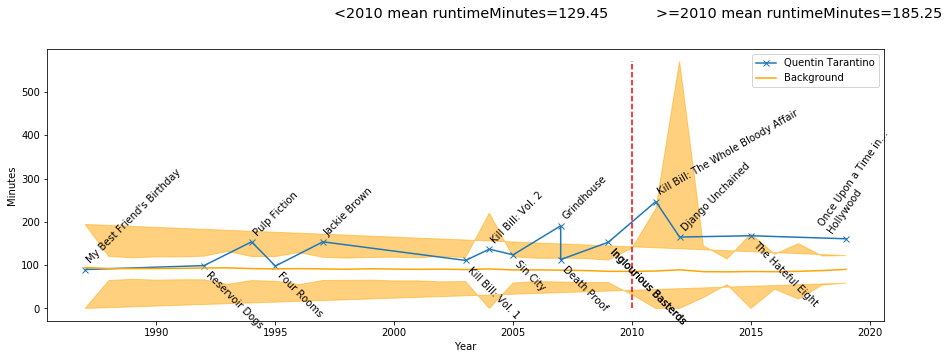

In [144]:
import numpy as np
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.plot(qt_movies['startYear'], qt_movies['runtimeMinutes'], 'x-', label='Quentin Tarantino')
plt.plot(average_run.index.values, average_run['runtimeMinutes'], label='Background', color='orange')
plt.xlabel("Year")
plt.ylabel("Minutes")
lower_run = np.clip(average_run['runtimeMinutes'] - std_run['runtimeMinutes'], np.inf, 0)
# TODO: adding movie titles
plt.fill(std_run.index.values, lower_run, 
         average_run['runtimeMinutes'] + std_run['runtimeMinutes'], alpha=0.5, color='orange')
for i in range(0, len(qt_movies)):
  if i % 2 == 0 and i != 10 and i != 14:
    plt.text(qt_movies.loc[i, 'startYear'], qt_movies.loc[i, 'runtimeMinutes'] + 10, 
             qt_movies.loc[i, 'primaryTitle'], rotation=45, ha="left", va="bottom")
  elif i != 11 and i != 14:
    plt.text(qt_movies.loc[i, 'startYear'], qt_movies.loc[i, 'runtimeMinutes'] - 10, 
             qt_movies.loc[i, 'primaryTitle'], rotation=-45, ha="left", va="top")

plt.text(qt_movies.loc[10, 'startYear'], qt_movies.loc[10, 'runtimeMinutes'] - 10, 
             qt_movies.loc[10, 'primaryTitle'], rotation=-45, ha="left", va="top")
plt.text(qt_movies.loc[11, 'startYear'], qt_movies.loc[11, 'runtimeMinutes'] + 10, 
             qt_movies.loc[11, 'primaryTitle'], rotation=30, ha="left", va="bottom")
plt.text(qt_movies.loc[14, 'startYear'] - 0.5, qt_movies.loc[14, 'runtimeMinutes'] + 10, 
             "Once Upon a Time in...\n Hollywood", rotation=55, ha="left", va="bottom", wrap=True)
max_time = max(average_run['runtimeMinutes'] + std_run['runtimeMinutes'])
plt.plot((2010, 2010), (0, max_time), '--', color='r')
plt.text(2011, max_time + 100, '>=2010 mean runtimeMinutes={:.2f}'.format(gt2010_mean), 
         ha="left", fontsize='x-large')
plt.text(2009, max_time + 100, '<2010 mean runtimeMinutes={:.2f}'.format(lt2010_mean), 
         ha="right", fontsize='x-large')
plt.legend(loc="best");

今天的**尋常一日的教學**就到這裡了！讓讀者帶回家並放在枕頭下，好在睡夢中也溫習的訊息有：   

1. 不要過度依賴 pandas.read_csv 的預設值，藉由檢視 pandas 讀進的資料型態，了解是否有解析錯誤。
2. NaN 很討人厭，但懂得如何和 NaN 和平共存是一個資料分析師的職業生涯中的重要功課。瞭解如何 masking 他們，如果你的函式沒有提供處理機制。
3. 在做 table join 時，若 join type 為字串時，盡量使之成為 index，會大幅減少運算時間。

最後，希望各位讀者都有收穫。